# Modelos lineales regularizados

## Instalación

In [26]:
R.version.string

[1] "R version 4.2.0 (2022-04-22)"

## Preparación de datos


In [27]:
unzip(zipfile = 'socialneighbor.zip')
social <- read.csv('socialneighbor.csv')

In [28]:
colnames(social)

[1] "sex"                          "yob"                         
 [3] "g2000"                        "g2002"                       
 [5] "g2004"                        "p2000"                       
 [7] "p2002"                        "cluster"                     
 [9] "votedav"                      "dem"                         
[11] "nov"                          "aug"                         
[13] "city"                         "hh_id"                       
[15] "hh_size"                      "totalpopulation_estimate"    
[17] "percent_male"                 "percent_female"              
[19] "median_age"                   "percent_under5years"         
[21] "percent_5to9years"            "percent_10to14years"         
[23] "percent_15to19years"          "percent_20to24years"         
[25] "percent_25to34years"          "percent_35to44years"         
[27] "percent_45to54years"          "percent_55to59years"         
[29] "percent_60to64years"          "percent_65to74years"         
[31] "percent_75to84years"          "percent_85yearsandolder"     
[33] "percent_18yearsandolder"      "percent_21yearsandover"      
[35] "percent_62yearsandover"       "percent_65yearsandover"      
[37] "percent_white"                "percent_black"               
[39] "percent_amindian_alaskan"     "percent_asian"               
[41] "percent_nativeandother"       "percent_other_nativeandother"
[43] "percent_hispanicorlatino"     "percent_race_other"          
[45] "median_income"                "mean_income"                 
[47] "employ_16"                    "unemploy_16"                 
[49] "unemploy_20to64"              "employ_20to64"               
[51] "employ_rename_20to64"         "hsorhigher"                  
[53] "bach_orhigher"                "less9thgrade"                
[55] "grade9to12"                   "highschool"                  
[57] "somecollege"                  "assoc"                       
[59] "bachelors"                    "grad"                        
[61] "outcome_voted"                "treatment_dum"               
[63] "treat_hawthorne"              "treat_civic"                 
[65] "treat_neighbors"              "treat_self"                  
[67] "randn"                        "oneperhh"                    
[69] "p2004"

In [29]:
set.seed(123)
noise.covars <- matrix(data = runif(nrow(social) * 13), 
                       nrow = nrow(social), ncol = 13)
noise.covars <- data.frame(noise.covars)
names(noise.covars) <- c("noise1", "noise2", "noise3", "noise4", "noise5", "noise6",
                         "noise7", "noise8", "noise9", "noise10", "noise11", "noise12","noise13")


Seleccionamos las covariables que vamos a trabajar. 
Si tenemos muchos datos y potencia de cálculo, entonces se recomienda usar todas las covariables y utilizar regularización. Esta recomendación se basa en la observación, ya que es más fácil arreglar problemas de sobre ajuste que de subajuste.

In [30]:
working <- cbind(social, noise.covars)

set.seed(333)
working <-  working[sample(nrow(social), 20000), ]

covariate.names <- c("yob", "hh_size", "sex", "city", "g2000","g2002", "p2000", "p2002", "p2004"
                     ,"totalpopulation_estimate","percent_male","median_age", "percent_62yearsandover"
                     ,"percent_white", "percent_black", "median_income",
                     "employ_20to64", "highschool", "bach_orhigher","percent_hispanicorlatino",
                     "noise1", "noise2", "noise3", "noise4", "noise5", "noise6",
                     "noise7", "noise8", "noise9", "noise10", "noise11", "noise12","noise13")


names(working)[names(working)=="outcome_voted"] <- "Y"
Y <- working[["Y"]]

In [31]:
names(working)[names(working)=="treat_neighbors"] <- "W"

In [32]:
W <- working[["W"]]
covariates <- working[covariate.names]

In [33]:
names(covariates)

[1] "yob"                      "hh_size"                 
 [3] "sex"                      "city"                    
 [5] "g2000"                    "g2002"                   
 [7] "p2000"                    "p2002"                   
 [9] "p2004"                    "totalpopulation_estimate"
[11] "percent_male"             "median_age"              
[13] "percent_62yearsandover"   "percent_white"           
[15] "percent_black"            "median_income"           
[17] "employ_20to64"            "highschool"              
[19] "bach_orhigher"            "percent_hispanicorlatino"
[21] "noise1"                   "noise2"                  
[23] "noise3"                   "noise4"                  
[25] "noise5"                   "noise6"                  
[27] "noise7"                   "noise8"                  
[29] "noise9"                   "noise10"                 
[31] "noise11"                  "noise12"                 
[33] "noise13"

Algunos algoritmos necesitan que las covariables sean escaladas para que funcionen mejor. En este caso vamos a usar la función "scale" para hacerlo.

In [34]:
covariates.scaled <- scale(covariates)
processed.unscaled <- data.frame(Y, W, covariates)
processed.scaled <- data.frame(Y, W, covariates.scaled)

El objetivo principal de machine learning es la predicción fuera de la muestra, es por eso que lo que se hace habitualmente para simularlo es partir la muestra de datos en dos, una muestra de entrenamiento y la otra de testeo. Incluso se suele dividir en tres también, lo que sería entrenamiento, validación y testeo. Para partir los datos usamos la función "sample"

In [35]:
# Creemos una función que nos devuelvo dos bd

train_test <- function(bd, porcentaje) {
    train <- sample(nrow(bd), round(nrow(bd)*porcentaje), replace = FALSE)
    train.bd <- bd[train,]
    test.bd <- bd[-train,]
    return(list(train.bd,test.bd))
    }

set.seed(45)
lista_train_test <- train_test(processed.scaled, 0.9)
y.train <- as.matrix(lista_train_test[[1]]$Y, ncol = 1)
y.test <- as.matrix(lista_train_test[[2]]$Y, ncol = 1)
X.train <- lista_train_test[[1]]
X.test <- lista_train_test[[2]]

Creamos las formulas que vamos a trabajar

In [36]:
sumx <- paste(covariate.names, collapse = " + ")  # "X1 + X2 + X3 + ..." for substitution later
interx <- paste(" (",sumx, ")^2", sep="")  # "(X1 + X2 + X3 + ...)^2" for substitution later
linear <- paste("Y", sumx, sep = "~")
linear <- as.formula(linear)
linear.inter <- (paste("Y", interx, sep = "~"))
linear.inter <- as.formula(linear.inter)

In [37]:
install.packages('glmnet')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Modelos lineales

### Mínimos cuadrados ordinarios

Cuándo hablamos de modelos lineales para predicción estamos suponiendo que la función $E(Y|X)$ es lineal en las entradas $X_1,...,X_p$. Por lo tanto podemos tomar un vector $X^T=(X_1,...,X_p)$ y predecir $y$ con la siguiente función:

\begin{equation}
f(X)=\beta_{0}+\sum_{j=1}^{p}\boldsymbol{X}_{j}\beta_{j}
\end{equation}

En esta ecuación los parámetros $\beta_j$ son desconocidos y $\boldsymbol{X}$ es una matriz de datos conocidos.
EL objetivo es estimar los coeficientes $\beta=\left(\beta_0,\beta_1,...,\beta_p\right)^T$, para esto, el método mas popular es el de mínimos cuadrados el cual tiene como objetivo reducir la suma de cuadrados de los residuos.

\begin{equation}
RSS\left(\beta\right) = \sum_{i=1}^{N}\left(y_i-\sum_{j=0}^{p}x_{ij}\beta_j\right)^2
\end{equation}

Para minimizarla podemos escrbirla de la siguiente forma:

\begin{equation}
RSS\left(\beta\right) = \left(\boldsymbol{y}-\boldsymbol{X}\beta\right)^T\left(\boldsymbol{y}-\boldsymbol{X}\beta\right)
\end{equation}

luego derivando e igualando a 0 tenemos:

\begin{equation}
\boldsymbol{X}^T\boldsymbol{y}-\boldsymbol{X}^T\boldsymbol{X}\beta = 0
\end{equation}

Asumiendo que $\boldsymbol{X}$ tiene rango completo de columnas podemos encontrar una única solución dada por:

\begin{equation}
\hat{\beta} = \left(\boldsymbol{X}^T\boldsymbol{X}\right)^{-1}\boldsymbol{X}^T\boldsymbol{y}
\end{equation}

Una condición necesaria para aplicar esta estimación es que las columnas de $\boldsymbol{X}$ sean independientes entre sí, en otro caso no tendríamos rango completo de columna. La función *lm* de R elimina aquellas columnas redundantes de la estimación y lo calcula, la mayoría de los software estadísticos lo hacen, pero no ocurre así si quisieramos aplicar este cálculo por nuestra cuenta.

Como se mencionó la función *lm* es el comando para calcular mínimos cuadrados en R. Los parámetros básicos para calcularla son una fórmula del objeto de tipo "formula" de R el cuál deberá tener cuál es la variable dependiente y cuales son las variables explicativas y la base de datos de dónde sale dicha información.

Procedemos a ver un ejemplo con los datos de social.csv


In [38]:
# la fórmula es
linear

Y ~ yob + hh_size + sex + city + g2000 + g2002 + p2000 + p2002 + 
    p2004 + totalpopulation_estimate + percent_male + median_age + 
    percent_62yearsandover + percent_white + percent_black + 
    median_income + employ_20to64 + highschool + bach_orhigher + 
    percent_hispanicorlatino + noise1 + noise2 + noise3 + noise4 + 
    noise5 + noise6 + noise7 + noise8 + noise9 + noise10 + noise11 + 
    noise12 + noise13

In [39]:
ols <- lm(linear, processed.scaled)
summary(ols)


Call:
lm(formula = linear, data = processed.scaled)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7623 -0.3418 -0.2178  0.5386  0.9980 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.320900   0.003179 100.953  < 2e-16 ***
yob                      -0.030616   0.003522  -8.694  < 2e-16 ***
hh_size                   0.010396   0.003365   3.089 0.002008 ** 
sex                      -0.007964   0.003186  -2.500 0.012434 *  
city                      0.040891   0.003407  12.002  < 2e-16 ***
g2000                    -0.007873   0.003510  -2.243 0.024897 *  
g2002                     0.030108   0.003503   8.595  < 2e-16 ***
p2000                     0.037473   0.003276  11.437  < 2e-16 ***
p2002                     0.058166   0.003308  17.582  < 2e-16 ***
p2004                     0.080485   0.003263  24.665  < 2e-16 ***
totalpopulation_estimate  0.010356   0.004097   2.528 0.011491 *  
percent_male             -0.002404

Como se puede ver, el método de mínimos cuadrados considera a los ruidos que agregamos nosotros como significativos, por lo tanto no tiene la capacidad de detectar que es ruido, simplemente las ajusta junto a todas las otras. Esto agrega otro supuesto más a MCO que tenemos que tener en cuenta, que es que tenemos que tener bien especificado el modelo, o sea todas las variables que pasamos como explicativas deben ser realmente las variables que explican a $y$. Esto es particularmente dificil en los casos reales, y la idea es tratar de encontrar las variables que explican el modelo a través de métodos de selección de variables, los cuales nos deberían acercar a la verdadera función.

De todas formas, si el método predice bien podemos tomarlo aunque tenga variables ruidosas, el objetivo acá es la predicción. Para chequear que tan bueno es un método para predcir por lo general se usa lo de partir la base de datos en dos, una grande que sirve para los datos de entrenamiento y otra más pequeña para el testeo. La idea es la predicción por fuera de la muestra. Luego con los coeficientes calculados con los datos de entrenamiento se predice sobre la base de prueba y se mide que tan efectivo es con alguna métrica.

In [40]:
ols <- lm(linear, data = X.train)

In [41]:
summary(ols)


Call:
lm(formula = linear, data = X.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7654 -0.3411 -0.2170  0.5382  1.0020 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.320276   0.003349  95.642  < 2e-16 ***
yob                      -0.032381   0.003714  -8.718  < 2e-16 ***
hh_size                   0.009691   0.003540   2.738  0.00620 ** 
sex                      -0.008945   0.003356  -2.665  0.00770 ** 
city                      0.042226   0.003575  11.811  < 2e-16 ***
g2000                    -0.009015   0.003703  -2.434  0.01492 *  
g2002                     0.029086   0.003681   7.902 2.91e-15 ***
p2000                     0.037072   0.003449  10.750  < 2e-16 ***
p2002                     0.058156   0.003485  16.688  < 2e-16 ***
p2004                     0.079698   0.003441  23.159  < 2e-16 ***
totalpopulation_estimate  0.009131   0.004324   2.112  0.03474 *  
percent_male             -0.002708   0.0040

Una forma de medir la efectividad del método para predecir es utilizando el error cuadrático medio, existen varias más, el error abosluto medio, el error logarítmico cuadrado medo, etc. Estos son los utilizados para medir la efectividad de las regresiones.

En R no están de manera predeterminada por lo tanto procedemos a armarlos con una función nosotros.

In [42]:
mse <- function(pred, y_test){
    return((mean((pred-y_test)^2)))
    }   

La función *predcit* en R es una función genérica que se puede aplicar a distintos objetos, solo que depende cual sea recibe parámetros distintos. Esto es parte de lo que se denomina *polimorfismo* en la programación orientada a objeto.

Es por eso que la hay que calcular las predicciones primero y luego calcular la métrica. Como se puede ver el primer número que es sobre la base de test, es mayor que sobre la base de entrenamiento, aunque son bastantes similares

In [43]:
ols_pred <- predict(ols, X.test)
ols_rdos <- c( mse_train = mse(predict(ols, X.train), y.train),mse_test = mse(ols_pred, y.test))
ols_rdos

mse_train  mse_test 
0.2014269 0.2048787

Esta son las métricas para evaluar una regresión, pero en nuestro ejemplo la variable respuesta es una variable binomial, por lo tanto es un problema de clasificación y no de regresión. Existen otro tipo de métricas para poder evaluar un método de estimación cuando el problema es de predicción, entre ellos los más conocidos son **precision** y **recall**. Para observar esto miremos lo que se conoce como matriz de confusión.


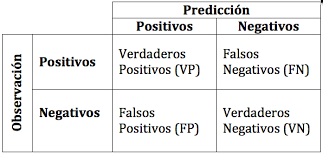


Entonces la precision o valor predictivo positivo  va medir a todos aquellos a los que predecimos como positivos y es verdad (verdaderos positivos) sobre todos los que predecimos como verdaderos. Más formal $VP/(VP+FP)$.

El recall o sensibilidad va medir a todos los verdaderos positivos sobre todos los que son positivos realmente. Más formal $VP/(VP+FN)$

La especificidad o razon de verdaderos negativos mide todos aquellos que son verdaderos negativos sobre todos los negativos reales. Más formal $VN/(FP+VN)$



Estos indicadores deben estar balanceados entre sí, no se puede intentar mejorar solo uno. Por ejemplo si aumentamos la precisión llevandola a 1, significa que acertamos a todos los que son verdaderamente positivos, pero esto, probablemente traiga aparejada que tenemos muchos falsos positivos también, por lo tanto puede ser indicio de sobre ajuste (*overfitting*). En cambio si mejoramos el recall, procurando no tener falsos negativos, puede dar indicios de sub-ajuste (*underfitting*). 

Existe unfa fórmula que los unifica a la precision y al recall para trabajar de manera unificada, estos se conocen como las medidas $F_1$. En este caso la fórmula es la siguiente:
\begin{equation}
F_1 = \frac{2}{1/prec+1/rec}
\end{equation}

Este indicador va de 0 a 1 siendo 1 el mejor resultado.



In [44]:
#definimos una función clasificadora de ols
clasif <- function(pred, p){
    r = pred > p
    return(as.numeric(r))
    }
clasif(ols_pred, 0.5)

[1] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [38] 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
  [75] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 [112] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [149] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [186] 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [223] 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 [260] 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 [297] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0
 [334] 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 [371] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 [408] 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 [445] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [482] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [519] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 [556] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 [593] 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1
 [630] 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 [667] 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 [704] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 [741] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [778] 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [815] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 [852] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [889] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 [926] 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 [963] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
[1000] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1
[1037] 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1074] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1111] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1148] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0
[1185] 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
[1222] 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
[1259] 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0
[1296] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
[1333] 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
[1370] 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
[1407] 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
[1444] 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1481] 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
[1518] 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1555] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
[1592] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1629] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
[1666] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1703] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
[1740] 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1777] 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1814] 0 0 0 0 0 0 0 1 0 0 0 0 0 0

In [45]:
confusion <- function(pred, y){
    vp = 0
    fp = 0
    fn = 0
    vn = 0
    for (i in 1:length(pred)){
        if(pred[i] == 1 ){
            if(pred[i] == y[i]){
                vp <- vp+1}
            else{
                fp <- fp+1}
               }
        else{
             if(pred[i] != y[i]){
                fn <- fn+1}
            else{
                vn <- vn+1
                }
            }}
        return(cbind(c(vp,fp),c(fn,vn)))
        }

f1_score <- function(pred,y) {
    val <- confusion(pred,y)
    prec <- val[1]/(val[1]+val[2])
    rec <- val[1]/(val[1]+val[3])
    f1 <- 2/(prec^-1+rec^-1)
    return(f1)}

In [46]:
confusion(clasif(ols_pred, 0.3),y.test)

482,173
697,648


In [47]:
ols_rdos['f1'] <- f1_score(clasif(ols_pred, 0.3),y.test)
ols_rdos['f1']

f1 
0.525627

### Modelo logit

El problema que tiene el modelo lineal para determinar una probabilidad, es que a menudo arroja valores negativos o valores mayores a 1, lo que no son valores que puedan identificarse como probabilidades. Para solucionar esto, se considera la función logística que devuelve todos valores entre 0 y 1.

\begin{equation}
p\left(y = 1|\boldsymbol{X}=x\right)=p\left(\boldsymbol{X}\right) = \frac{e^{\boldsymbol{X}\boldsymbol{\beta}}}{1+e^{\boldsymbol{X}\boldsymbol{\beta}}}
\end{equation}

Si aplicamos transformaciones podemos ver que la ecuación nos queda de la siguiente forma:

\begin{equation}
log\left(\frac{p\left(\boldsymbol{X}\right)}{1-p\left(\boldsymbol{X}\right)}\right) = \boldsymbol{X}\boldsymbol{\beta}
\end{equation}

la proporción $\frac{p\left(\boldsymbol{X}\right)}{1-p\left(\boldsymbol{X}\right)}$ se denomina *odds*, y puede tomar valores que van del 0 al $\infty$. Como podemos ver el modelo de regresión sigue siendo lineal en $\boldsymbol{X}$ pero con respecto al *log-odds* que es como se denomina a la parte de la izquierda de la ecuación anterior.

La forma de estimar este modelo es a través de máxima verosimilitud, en el cual no vamos a entrar en detalles acá.

Para realizar la estimación en R, se utiliza la función *glm*. La forma de uso es muy similar a *lm* necesita que le pasemos la fórmula a estimar y los datos necesarios como variables principales. Además se le agrega la variable *family* en la cual hay que colocarle que queremos estimar una *binomial*. Esta función en R es mucho más amplia que solo para estimar modelos logit, en realidad funcióna para estimar cualquier modelo lineal generalizado, lo que hay que variar es el parámetro *family*.

In [49]:
logit <- glm(linear, data = X.train, family = "binomial")

In [50]:
summary(logit)


Call:
glm(formula = linear, family = "binomial", data = X.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7773  -0.8954  -0.6840   1.2288   2.2556  

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -0.822343   0.017063 -48.194  < 2e-16 ***
yob                      -0.165226   0.018221  -9.068  < 2e-16 ***
hh_size                   0.030684   0.017553   1.748 0.080455 .  
sex                      -0.043937   0.016658  -2.637 0.008352 ** 
city                      0.200179   0.017007  11.770  < 2e-16 ***
g2000                    -0.028670   0.018959  -1.512 0.130495    
g2002                     0.173736   0.019822   8.765  < 2e-16 ***
p2000                     0.176454   0.016548  10.663  < 2e-16 ***
p2002                     0.280747   0.016992  16.522  < 2e-16 ***
p2004                     0.391560   0.017080  22.925  < 2e-16 ***
totalpopulation_estimate  0.044992   0.021592   2.084 0.037187 *  
p

La función predict también es aplicable a los modelos logit, pero a estos hay que agregarles el parámetro *type* en el cual hay que poner response. En otro caso, nos devolvera la probabilidad en escala logarítmica.

In [51]:
logit_pred <- predict(logit,X.test, type = "response")
logit_rdos <- c('mse_logit' = mse(predict(logit, type = "response"), y.train),',mse_test' = mse(logit_pred, y.test)) 
logit_rdos

mse_logit ,mse_test 
0.2013715 0.2047705

In [52]:
# La fórmula predict en el logit devuelve una probabilidad entonces tampoco arroja valores 0 o 1 como la clasificación que queremos, por lo tanto lo tenemos que separar en base a un criterio
# usamos la función creada antes
clasif(logit_pred, 0.5) 
logit_rdos['f1'] <- f1_score(clasif(logit_pred, 0.3) , y.test)

[1] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [38] 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0
  [75] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 [112] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [149] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [186] 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [223] 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 [260] 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 [297] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0
 [334] 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 [371] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 [408] 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 [445] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [482] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [519] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 [556] 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 [593] 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1
 [630] 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 [667] 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 [704] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 [741] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [778] 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [815] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 [852] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [889] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0
 [926] 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 [963] 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
[1000] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1
[1037] 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
[1074] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1111] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1148] 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0
[1185] 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
[1222] 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0
[1259] 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0
[1296] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1
[1333] 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
[1370] 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0
[1407] 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
[1444] 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1481] 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
[1518] 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1555] 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
[1592] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1629] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
[1666] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1703] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
[1740] 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1777] 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1814] 0 0 0 0 0 0 0 1 0 0 0 0 0 0

In [53]:
logit_rdos['f1']

f1 
0.5269805

In [54]:
# ponemos ambos modelos en un df que va agrupando los resultados
rdos <- cbind(ols_rdos,logit_rdos)
rdos

,ols_rdos,logit_rdos
mse_train,0.2014269,0.2013715
mse_test,0.2048787,0.2047705
f1,0.5256270,0.5269805


### Regresion con descomposición de valores singulares

Un método utilizado por los sowtwares de predicción en machine learning es la regresión utilizando la pseudo inversa de la matriz de datos. Para encontrar dicha pseudo-inversa se utiliza la descomposición de valores singulares. Sea $X$ una matriz $n\ \times\  p$ 

\begin{equation}
X = U\Sigma V^T
\end{equation}

siendo $U$ una matriz $n\ \times\ n$ , $\Sigma$ es una matriz $m\ \times\ p$ y $V^T$ es una matriz cuadrada $p\ \times\ p$. Las matrices $U$ y $V^T$ son matrices unitarias lo que les da unas propiedades muy convenientes ya que $UU^T\ =\ I$ y $VV^T\ =\ I$. Por otro lado $\Sigma$ es una matriz diagonal sólo en en sus primeros $r$ renglones siendo $r=\ min(n,p)$ llenando todos los demás espacios con ceros, que suelen eliminarse. La primera ventaja que proporciona este método es que no importa la forma de la matriz, siempre se puede descomponer en estas tres matrices mencionadas, incluso cuando $p > n$.

Dado un sistema de ecuaciones, podemos resolverlo con la descomposición mencionada.

\begin{equation}
X\beta\ =\ y 
\end{equation}

\begin{equation}
(U\Sigma V^T)^{-1}(U\Sigma V^T)\beta\ =\ (U\Sigma V^T)^{-1}y 
\end{equation}

\begin{equation}
\hat{\beta}\ =\ V\Sigma^{-1}U^Ty
\end{equation}

Cómo vemos las matriz descompuesta es muy fácil de invertir. La complejidad computacional en usar este método es al rededor de $O\left(n^2\right)$ mientras que con el método normal la complejidad es de alrededor de $O\left(n^{2.4}\right)$ hasta $O\left(n^3\right)$

En R podemos encontrar la función *svd* que permite descomponer las matrices, luego con está podemos construir la regresión.

In [55]:
# está función reg.svm devuelve los coeficientes calculados bajo este método
reg.svm <- function(modelo, y,X) {
    X <- model.matrix(modelo,X) #la función model.matrix devuleve la matriz de acuerdo a la fórmula
    dX <- svd(X)
    x_hat <- (dX$v) %*% solve(diag(dX$d)) %*% t(dX$u) %*% y
    #y_pred <- X %*% x_hat
    return(x_hat)
    }
#creamos una función predict

predict.svm <- function(modelo, X, coef){
    pred <- model.matrix(modelo,X) %*% coef
    return(pred)
           }


In [56]:
coef <- reg.svm(linear, y.train, X.train)
pred_train <- predict.svm(linear, X.train, coef)
pred_test <- predict.svm(linear, X.test, coef)

svm_rdos <- c('mse_train' = mse(pred_train, y.train), 'mse_test' = mse(pred_test, y.test))
svm_rdos

mse_train  mse_test 
0.2014269 0.2048787

In [57]:
#sigue con el mismo problema de clasificación usamos la función clasif creada y calculamos el f1
svm_rdos['f1'] <- f1_score(clasif(pred_test,0.3), y.test)
svm_rdos['f1']

f1 
0.525627

In [58]:
rdos <- cbind(rdos,svm_rdos)
rdos

,ols_rdos,logit_rdos,svm_rdos
mse_train,0.2014269,0.2013715,0.2014269
mse_test,0.2048787,0.2047705,0.2048787
f1,0.5256270,0.5269805,0.5256270


### Ridge regresión

El teorema Gauss-Markov dice que el estimador de mínimos cuadrados es el mejor estimador lineal insesgado, pero puede ser que exista un estimador que sea sesgado y mejor. Esta discusión pasa por un trade-off entre el sesgo y la varianza muy usual en machine learning, como los objetivos acá no son la estimación si no la predicción se prefiere un estimador que sea sesgado mientras disminuya la varianza. Esto sucede con los estimadores restringidos. 

El estimador que proviene de la ridge regresión surje de solucionar el siguiente problema:

\begin{equation}
\hat{\beta}^{ridge} = argmin_β\left(y_i-\beta_0-\sum_{j=1}^p\beta_j^2x_{ij}\right)^2
\end{equation}
\begin{equation}
sujeto\ a\ \sum_{j=1}^p\beta_j^2\ <= t
\end{equation}

Resolviendo el problema el estimador nos queda de la siguiente forma:

\begin{equation}
\hat{\beta}^{ridge} = argmin_β\left\{\left(y_i-\beta_0-\sum_{j=1}^p\beta_j^2x_{ij}\right)^2 + λ\sum_{j=1}^p\beta_j^2\right\}
\end{equation}

El parámetro $\lambda$ es el que regulariza los estimadores llevando a 0 los parámetros. La regresión ridge no es invariante a las escalas de los parámetros, es por eso que se deben estandarizar las variables previo a hacer los cálculos. 

Si escribimos el problema en forma matricial nos queda de la siguiente forma:

\begin{equation}
\hat{\beta}^{ridge} = \left(\boldsymbol{X}^T\boldsymbol{X}+\lambda\boldsymbol{I} \right)^{-1}\boldsymbol{X}^T\boldsymbol{y} 
\end{equation}

La matriz $\boldsymbol{X}^T\boldsymbol{X}$ puede no tener rango completo, incluso son los principales problemas perseguidos con este tipo de regresión y la forma de solucionarlo es con la descomposición de valores singulares.


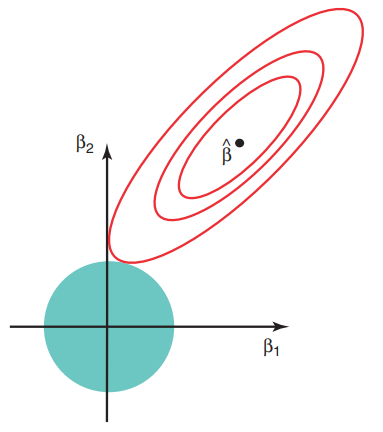

Para trabajar la regresión ridge y LASSO usamos el paquete glmnet y la función de ese mismo paquete. La forma de determinar cual vamos a utilizar es con el parámtero alpha, si este es 0 la regresión es ridge y si es 1 es LASSO.

EL parámetro a identficar es el parámetro  λ , no hay una forma de saber que valor poner a este parámetro por eso lo ideal es hacer varias regresiones y tomar el que mejores resultados, para ello se hace un grid con un rango de posibles valores para lambda, en este caso desde  1010  hasta  10−2

In [59]:
library(glmnet)
grid <- 10^seq(10,-2, length = 100)
ridge.mod <- glmnet(model.matrix(linear, X.train), y.train, alpha = 0, lambda = grid)

Loading required package: Matrix

Loaded glmnet 4.1-4



Lo que la función "glmnet" ha hecho ahora es calcular 100 regresiones para los distintos valores de $\lambda$ que le pasamos, por lo tanto cuando queremos consultar los coeficientes que arroja el modelo, se hace con el método "coef" y este va arrojar una matriz de k * 100 siendo k la cantidad de coeficientes que estamos estimando.

In [60]:
dim(coef(ridge.mod))

[1]  35 100

El hiper parámetro $\lambda$ se selecciona con cross-validation. Recordemos que la elección de los bloques en las carpetas de cross-validation se hace de manera aleatoria, entonces para poder repetir el experimento es necesario pasarle una semilla al software, así siempre nos arroja los mismos datos

Para ejecutar la cross-validation en R se utiliza la función cv.glmnet y los parámetros que recibe son los mismos que los que recibe glmnet y se le agregan los de cross-validations. El argumento lambda es opcional, se puede pasar una lista propia o si se deja vació el programa tomara distintos lambda por defecto. La cantidad de carpetas está por defecto en 10 que también puede ser modificada. Entre los argumentos de salida podemos encontrar a lambda.min que representa el valor de lambda que minimiza el error.


[1] 0.006975533

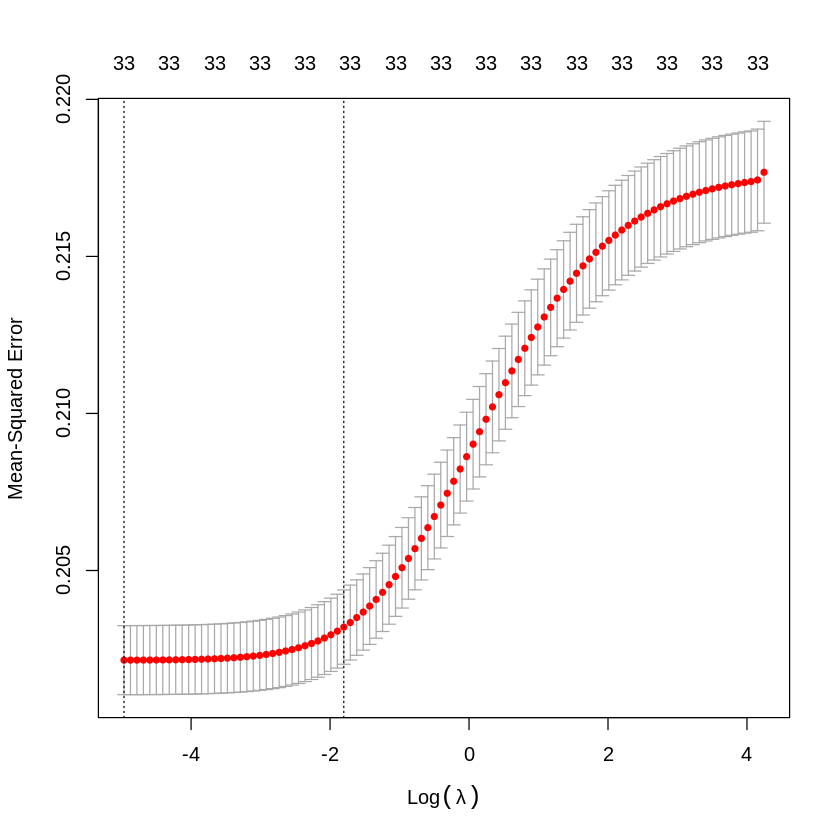

In [63]:
set.seed(154)
cv_ <- cv.glmnet(model.matrix(linear,X.train), y.train, alpha = 0)
plot(cv_)
bestlam <- cv_$lambda.min
bestlam

La función plot aplicada al objeto de cv.glmnet nos muestra un gráfico con los valores de lambda y el error cuadrático medio en el eje y. En este caso se muestra que si incrementamos la penalización el error se va incrementando.

Para predecir los valores volvemos a usar la función predict solo que en este caso le debemos pasar el argumento "s", que se refiere al valor de lambda por el cual queremos estimar.

In [64]:
str(cv_)

List of 12
 $ lambda    : num [1:100] 69.8 63.6 57.9 52.8 48.1 ...
 $ cvm       : num [1:100] 0.218 0.217 0.217 0.217 0.217 ...
 $ cvsd      : num [1:100] 0.00162 0.00162 0.00161 0.00161 0.00161 ...
 $ cvup      : num [1:100] 0.219 0.219 0.219 0.219 0.219 ...
 $ cvlo      : num [1:100] 0.216 0.216 0.216 0.216 0.216 ...
 $ nzero     : Named int [1:100] 33 33 33 33 33 33 33 33 33 33 ...
  ..- attr(*, "names")= chr [1:100] "s0" "s1" "s2" "s3" ...
 $ call      : language cv.glmnet(x = model.matrix(linear, X.train), y = y.train, alpha = 0)
 $ name      : Named chr "Mean-Squared Error"
  ..- attr(*, "names")= chr "mse"
 $ glmnet.fit:List of 12
  ..$ a0       : Named num [1:100] 0.32 0.32 0.32 0.32 0.32 ...
  .. ..- attr(*, "names")= chr [1:100] "s0" "s1" "s2" "s3" ...
  ..$ beta     :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:3300] 1 2 3 4 5 6 7 8 9 10 ...
  .. .. ..@ p       : int [1:101] 0 33 66 99 132 165 198 231 264 297 ...
  .. .. ..@ Dim     :

In [65]:
bestlam <- cv_$lambda.1se

In [66]:
ridge.pred <- predict(ridge.mod, s= bestlam, newx = (model.matrix(linear, X.test)))
ridge.pred.train <- predict(ridge.mod, s=bestlam, newx = model.matrix(linear, X.train))

ridge_rdos <- c('mse_train' = mse(ridge.pred.train, y.train), 'mse_test' = mse(ridge.pred, y.test))
ridge_rdos

mse_train  mse_test 
0.2026786 0.2059849

In [69]:
# aplciamos clasificación
clas <- clasif(ridge.pred, 0.3)
ridge_rdos['f1'] <- f1_score(clas, y.test)
ridge_rdos['f1']

f1 
0.5110178

In [70]:
rdos <- cbind(rdos, ridge_rdos)
rdos

,ols_rdos,logit_rdos,svm_rdos,ridge_rdos
mse_train,0.2014269,0.2013715,0.2014269,0.2026786
mse_test,0.2048787,0.2047705,0.2048787,0.2059849
f1,0.5256270,0.5269805,0.5256270,0.5110178


In [71]:
# si queremos ver los coeficientes hay que agregar el argumento "coefficients"
predict(ridge.mod, type = "coefficients", s = bestlam)

35 x 1 sparse Matrix of class "dgCMatrix"
                                    s1
(Intercept)               0.3202556238
(Intercept)               .           
yob                      -0.0243248695
hh_size                   0.0025780563
sex                      -0.0071760339
city                      0.0296312047
g2000                    -0.0013381055
g2002                     0.0244261651
p2000                     0.0274413471
p2002                     0.0423239881
p2004                     0.0560606044
totalpopulation_estimate  0.0033139568
percent_male             -0.0021586550
median_age                0.0041161993
percent_62yearsandover    0.0072783702
percent_white             0.0046314975
percent_black             0.0043544260
median_income             0.0059575385
employ_20to64            -0.0050131691
highschool                0.0049921674
bach_orhigher            -0.0018615052
percent_hispanicorlatino -0.0005879791
noise1                   -0.0055543559
noise2                

### LASSO

La regresión LASSO es muy similar a la ridge, la diferencia es que se cambia la penalización $L2$ (el cuadrdado de los parámetros)  por la penalización $L1$ (valor absoluto de los parámetros). 

\begin{equation}
\hat{\beta}^{lasso} = argmin_β\left(y_i-\beta_0-\sum_{j=1}^p\beta_j^2x_{ij}\right)^2
\end{equation}
\begin{equation}
sujeto\ a\ \sum_{j=1}^p|\beta_j|\ <= t
\end{equation}

Resolviendo el problema el estimador nos queda de la siguiente forma:

\begin{equation}
\hat{\beta}^{lasso} = argmin_β\left\{\left(y_i-\beta_0-\sum_{j=1}^p\beta_j^2x_{ij}\right)^2 + λ\sum_{j=1}^p|\beta_j|\right\}
\end{equation}

La restricción de esta regresión lleva los parametros $\beta$ hacia 0 anulando los que no son relevantes para la solución del problema, a diferencia de la ridge que se acerca a 0 asintóticamente. Esta regresión es muy útil para la selección de variables es por eso que ultimamente es más utilizada que la ridge. 


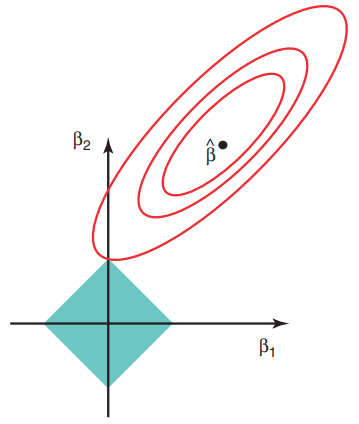

Como ya había mencionado la función para calcular lasso es la misma que la de ridge, solo que ahora se le cambia el parámetro alpha y se pone en valor 1. Lo demás funciona de la mísma manera

In [72]:
lasso.mod <- glmnet(model.matrix(linear, X.train), y.train, alpha = 1, lambda = grid)


[1] 0.01085167

mse_train  mse_test        f1 
0.2030162 0.2058538 0.5166052

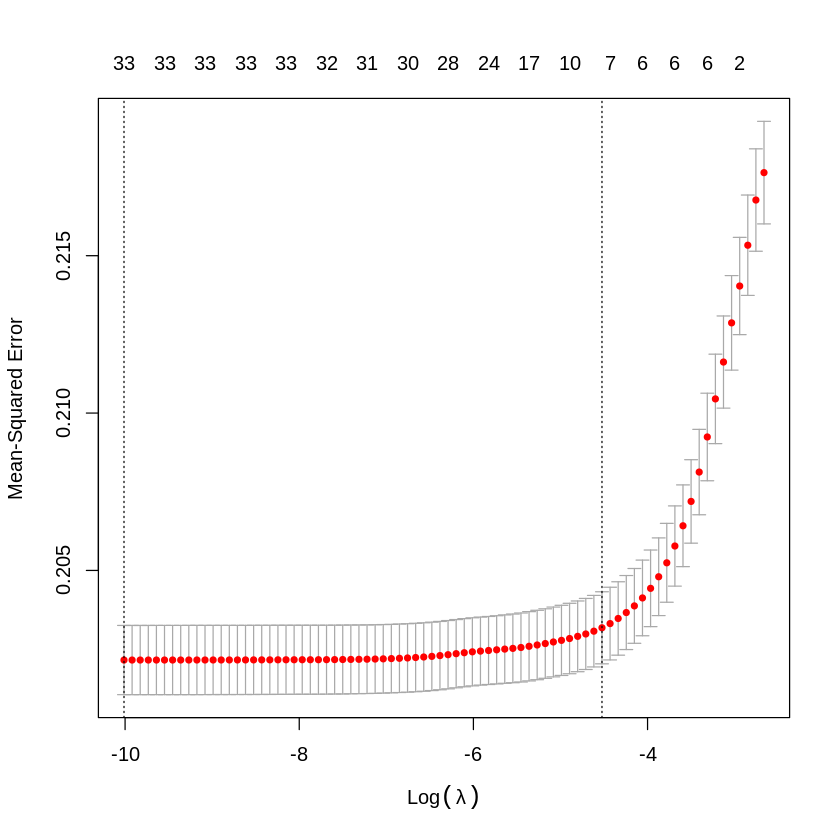

In [74]:
set.seed(154)

cv_lasso <- cv.glmnet(model.matrix(linear,X.train), y.train, alpha = 1)
plot(cv_lasso)
bestlam <- cv_lasso$lambda.1se
bestlam

lasso.pred <- predict(cv_lasso, s= bestlam, newx = model.matrix(linear,X.test))
lasso.pred.train <- predict(cv_lasso, s= bestlam, newx = model.matrix(linear,X.train))
clas <- clasif(lasso.pred, 0.3)

lasso_rdos <- c('mse_train' = mse(lasso.pred.train, y.train), 'mse_test' = mse(lasso.pred, y.test), 'f1' = f1_score(clas, y.test))
lasso_rdos

In [78]:
predict(cv_lasso, type = "coefficients", s = bestlam)

35 x 1 sparse Matrix of class "dgCMatrix"
                                  s1
(Intercept)               0.32025000
(Intercept)               .         
yob                      -0.02309573
hh_size                   .         
sex                       .         
city                      0.02804205
g2000                     .         
g2002                     0.02054057
p2000                     0.02717781
p2002                     0.04872277
p2004                     0.06588709
totalpopulation_estimate  .         
percent_male              .         
median_age                .         
percent_62yearsandover    0.00287566
percent_white             .         
percent_black             .         
median_income             .         
employ_20to64             .         
highschool                .         
bach_orhigher             .         
percent_hispanicorlatino  .         
noise1                    .         
noise2                    .         
noise3                    .      

Otro argumento de salida que ofrece glmnet es "lambda.1se" este no es el mínimo lambda es pero es el valor que más regulariza y se encuentra dentro del error estandard del mínimo. Se suele utilizar mucho porque a los efectos de seleccionar variables es más estricto.

In [79]:
rdos <- cbind(rdos, lasso_rdos)
rdos

,ols_rdos,logit_rdos,svm_rdos,ridge_rdos,lasso_rdos
mse_train,0.2014269,0.2013715,0.2014269,0.2026786,0.2030162
mse_test,0.2048787,0.2047705,0.2048787,0.2059849,0.2058538
f1,0.5256270,0.5269805,0.5256270,0.5110178,0.5166052


### Ridge y Lasso para una regresión logística

Ante el mismo problema de clasificación podemos transformar a ridge o LASSO en una regresión logística agregando el argumento "family = 'binomial'" al comando glmnet o cv.glmnet

In [80]:
ridge.logit <- glmnet(model.matrix(linear,X.train), y.train, alpha = 0, family = 'binomial')


In [81]:
lasso.logit <- glmnet(model.matrix(linear,X.train), y.train, alpha = 1, family = 'binomial')


podemos obtener los coeficientes para uno o mas valoresd e $\lambda$

In [86]:
coef(lasso.logit, s = c(0.03457, 0.007))

35 x 3 sparse Matrix of class "dgCMatrix"
                                  s1           s2        s3
(Intercept)              -0.76263628 -0.802671644 -0.753006
(Intercept)               .           .            .       
yob                      -0.04292769 -0.131787608  .       
hh_size                   .           .            .       
sex                       .          -0.012953482  .       
city                      0.01896597  0.150813394  .       
g2000                     .           .            .       
g2002                     0.04394236  0.136213965  .       
p2000                     0.02823405  0.144339964  .       
p2002                     0.13547926  0.246851437  .       
p2004                     0.17849446  0.339003760  .       
totalpopulation_estimate  .           .            .       
percent_male              .           .            .       
median_age                .           0.005868856  .       
percent_62yearsandover    .           0.022527526  .      

In [87]:
pre.lasso.logit <- predict(lasso.logit, newx = model.matrix(linear, X.test), 
                   s = c(0.03457, 0.007), type = "response")

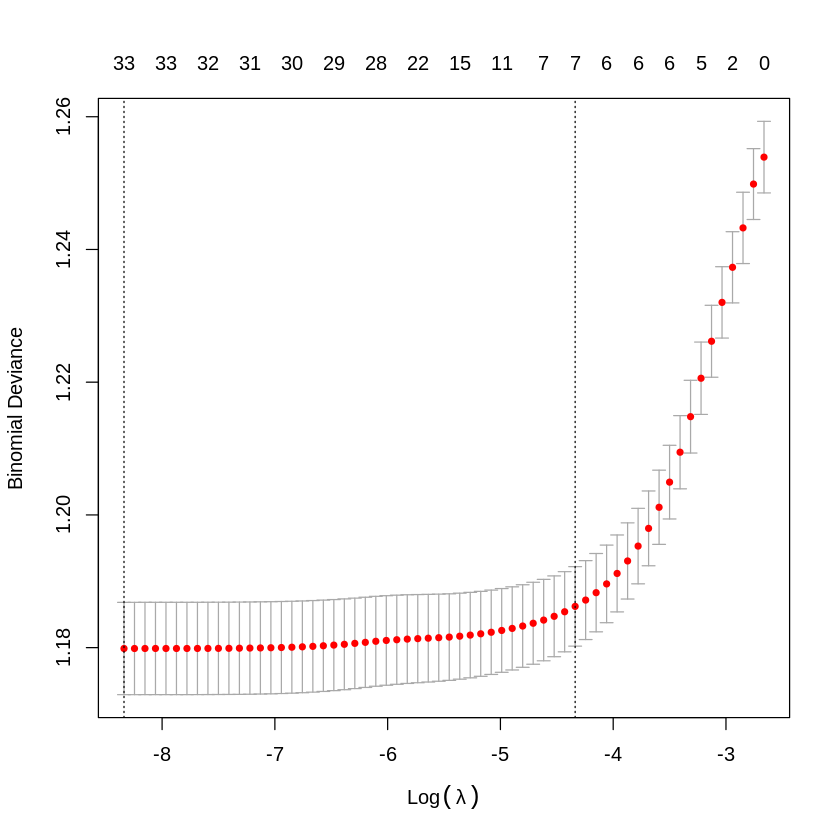

In [88]:
#usamos cross validation
cv.glm.logit <- cv.glmnet(model.matrix(linear,X.train), y.train, alpha = 1, family = 'binomial')
plot(cv.glm.logit)


In [89]:
bestlam <- cv.glm.logit$lambda.1se
coef(cv.glm.logit, s = bestlam)

35 x 1 sparse Matrix of class "dgCMatrix"
                                   s1
(Intercept)              -0.790200369
(Intercept)               .          
yob                      -0.113186848
hh_size                   .          
sex                       .          
city                      0.120477891
g2000                     .          
g2002                     0.112129100
p2000                     0.118767212
p2002                     0.221214635
p2004                     0.301776513
totalpopulation_estimate  .          
percent_male              .          
median_age                .          
percent_62yearsandover    0.004202066
percent_white             .          
percent_black             .          
median_income             .          
employ_20to64             .          
highschool                .          
bach_orhigher             .          
percent_hispanicorlatino  .          
noise1                    .          
noise2                    .          
noise3  

In [91]:
pre.cv.glm.logit <- as.vector(predict(cv.glm.logit, newx = model.matrix(linear,X.test), s = bestlam, type = "response" ))
pre.cv.glm.train <- as.vector(predict(cv.glm.logit, newx = model.matrix(linear,X.test), s = bestlam,type = "response"))
pre.lasso.logit <- clasif(pre.cv.glm.logit,0.3)
#predict(cv.glm.logit, newx = model.matrix(linear,X.test), s = bestlam, type = 'class')

lasso_logit_rdos <- c('mse_train' = mse(pre.cv.glm.train,y.train), 'mse_test' = mse(pre.cv.glm.logit, y.test), 'f1' = f1_score(pre.lasso.logit, y.test))
lasso_logit_rdos

mse_train  mse_test        f1 
0.2263187 0.2058102 0.5157438

In [92]:
rdos <- cbind(rdos, lasso_logit_rdos)
rdos

,ols_rdos,logit_rdos,svm_rdos,ridge_rdos,lasso_rdos,lasso_logit_rdos
mse_train,0.2014269,0.2013715,0.2014269,0.2026786,0.2030162,0.2263187
mse_test,0.2048787,0.2047705,0.2048787,0.2059849,0.2058538,0.2058102
f1,0.5256270,0.5269805,0.5256270,0.5110178,0.5166052,0.5157438


### Elastic net

El método *elastic net* junta las penalizaciones $L1$ y $L2$ en un solo algoritmo. La fórmula del estimador quedaría de la siguiente forma:

\begin{equation}
\hat{\beta}^{en} = argmin_β\left\{\left(y_i-\beta_0-\sum_{j=1}^p\beta_j^2x_{ij}\right)^2 + (1-\alpha) λ\sum_{j=1}^p\beta_j^2+\alpha\lambda\sum_{j=1}^p|\beta_j|\right\}
\end{equation}

Es muy similar a los anteriores solo que ajusta con un parámetro $\alpha$ a cual penalización le da más importancia, LASSO y ridge son casos particulares de elastic net cuando $\alpha = 1$ y cuando $\alpha = 0$ respectivamente.

De esta misma forma se trabaja en R, con la misma función glmnet salvo que ahora el parámetro alpha va estar dentro del intérvalo $(0,1)$. Siendo todo lo demás igual


In [93]:
elastnet.reg <- glmnet( X.train, y.train, alpha = 0.8)

Warning message in plotCoef(x$beta, lambda = x$lambda, df = x$df, dev = x$dev.ratio, :
“1 or less nonzero coefficients; glmnet plot is not meaningful”


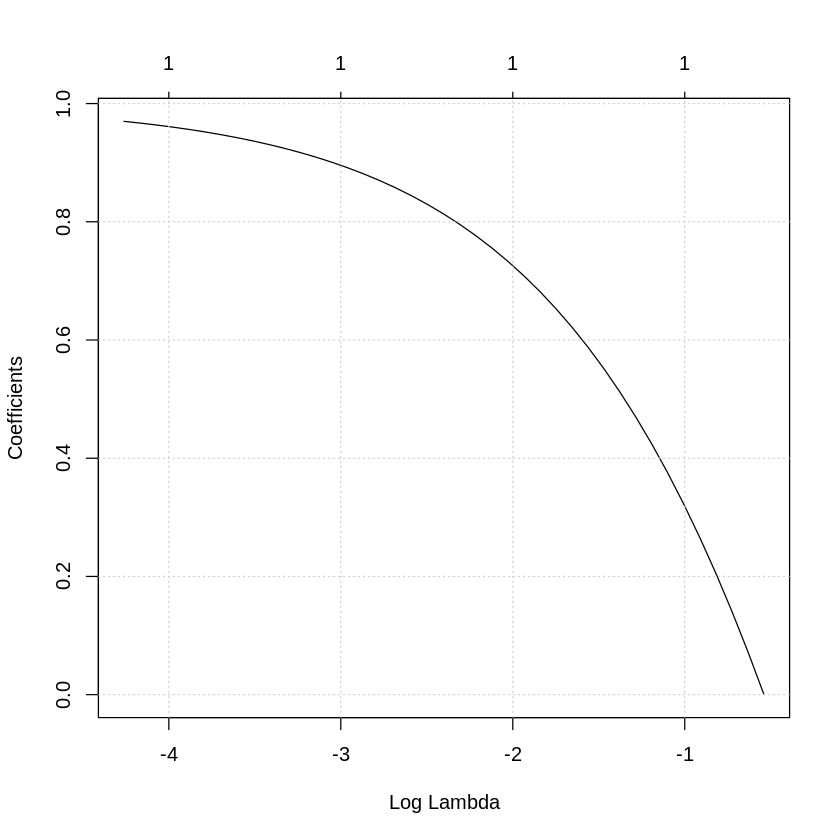

In [94]:
plot(elastnet.reg, xvar = "lambda", label = FALSE)
grid()

La función cv.glmnet no aplica cross-validation sobre el parámetro alpha por lo tanos eso se debe hacer probando varios coeficientes.

In [95]:
elastnet.logit <- cv.glmnet( model.matrix(linear,X.train), y.train, alpha = 0.8, family = 'binomial')
optlambda <- elastnet.logit$lambda.1se

pre.elastnet <- as.vector(predict(elastnet.logit, newx = model.matrix(linear,X.test), s = optlambda, type = "response" ))
pre.elastnet.train <- as.vector(predict(elastnet.logit, newx = model.matrix(linear,X.train), s = optlambda,type = "response"))
pre.elastnet.logit <- clasif(pre.elastnet,0.3)

elastnet_logit_rdos <- c('mse_train' = mse(pre.elastnet.train,y.train), 'mse_test' = mse(pre.elastnet, y.test), 'f1' = f1_score(pre.elastnet.logit, y.test))
elastnet_logit_rdos

mse_train  mse_test        f1 
0.2034593 0.2060596 0.5148729

In [96]:
rdos <- cbind(rdos, elastnet_logit_rdos)
rdos

,ols_rdos,logit_rdos,svm_rdos,ridge_rdos,lasso_rdos,lasso_logit_rdos,elastnet_logit_rdos
mse_train,0.2014269,0.2013715,0.2014269,0.2026786,0.2030162,0.2263187,0.2034593
mse_test,0.2048787,0.2047705,0.2048787,0.2059849,0.2058538,0.2058102,0.2060596
f1,0.5256270,0.5269805,0.5256270,0.5110178,0.5166052,0.5157438,0.5148729


In [97]:
coef(cv.glm.logit, s = optlambda)

35 x 1 sparse Matrix of class "dgCMatrix"
                                  s1
(Intercept)              -0.78190667
(Intercept)               .         
yob                      -0.09678040
hh_size                   .         
sex                       .         
city                      0.09717209
g2000                     .         
g2002                     0.09475690
p2000                     0.09799619
p2002                     0.20109501
p2004                     0.27272869
totalpopulation_estimate  .         
percent_male              .         
median_age                .         
percent_62yearsandover    .         
percent_white             .         
percent_black             .         
median_income             .         
employ_20to64             .         
highschool                .         
bach_orhigher             .         
percent_hispanicorlatino  .         
noise1                    .         
noise2                    .         
noise3                    .      

### MCO con variables seleccionadas por LASSO

In [98]:
coef_lasso <- predict(cv_lasso, type = "nonzero") # otra forma de estimar los coeficientes
col <-colnames(model.matrix(linear,X.train))
sel.var <- col[unlist(coef_lasso)]
sel.var

[1] "yob"                    "city"                   "g2002"                 
[4] "p2000"                  "p2002"                  "p2004"                 
[7] "percent_62yearsandover"

In [99]:
# creamos la fórmula con las variables que quedan
linear_lasso <- paste('Y', paste(sel.var, collapse = " + ") , sep = " ~ ")
linear_lasso <- as.formula(linear_lasso)
linear_lasso

Y ~ yob + city + g2002 + p2000 + p2002 + p2004 + percent_62yearsandover

In [100]:
ols_lasso <- lm(linear_lasso, data = X.train)
summary(ols_lasso)


Call:
lm(formula = linear_lasso, data = X.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7259 -0.3420 -0.2201  0.5460  0.9886 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             0.320253   0.003354  95.493  < 2e-16 ***
yob                    -0.028519   0.003515  -8.114 5.22e-16 ***
city                    0.039042   0.003378  11.559  < 2e-16 ***
g2002                   0.026301   0.003526   7.458 9.15e-14 ***
p2000                   0.036430   0.003408  10.691  < 2e-16 ***
p2002                   0.057415   0.003476  16.517  < 2e-16 ***
p2004                   0.077995   0.003393  22.985  < 2e-16 ***
percent_62yearsandover  0.011635   0.003399   3.423  0.00062 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4499 on 17992 degrees of freedom
Multiple R-squared:  0.07032,	Adjusted R-squared:  0.06996 
F-statistic: 194.4 on 7 and 17992 DF,  p-value: < 2.2e-16


In [102]:
pred_ols.lasso.train <- predict(ols_lasso, X.train)
pred_ols.lasso <- predict(ols_lasso, X.test)
clas <- clasif(pred_ols.lasso, 0.3) 
ols_lasso_rdos <- c('mse_train' = mse(pred_ols.lasso.train, y.train), 'mse_test' = mse(pred_ols.lasso, y.test), 'f1' = f1_score(clas,y.test))
ols_lasso_rdos

mse_train  mse_test        f1 
0.2023535 0.2055053 0.5180398

In [103]:
rdos <- cbind(rdos, ols_lasso_rdos)
rdos

,ols_rdos,logit_rdos,svm_rdos,ridge_rdos,lasso_rdos,lasso_logit_rdos,elastnet_logit_rdos,ols_lasso_rdos
mse_train,0.2014269,0.2013715,0.2014269,0.2026786,0.2030162,0.2263187,0.2034593,0.2023535
mse_test,0.2048787,0.2047705,0.2048787,0.2059849,0.2058538,0.2058102,0.2060596,0.2055053
f1,0.5256270,0.5269805,0.5256270,0.5110178,0.5166052,0.5157438,0.5148729,0.5180398
